In [1]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import os
import sys
import time
from collections import deque
import timeit
import logging

import numpy as np
import torch
from baselines.logger import HumanOutputFormat

from level_replay import utils
from level_replay.algo.dqn import RainbowDQN, DQN
from level_replay.algo.policy import Rainbow, DDQN
from level_replay.algo.buffer import Buffer, PrioritizedBuffer
from level_replay.model import model_for_env_name
from level_replay.storage import RolloutStorage
from level_replay.file_writer import FileWriter
from level_replay.envs import make_lr_venv
from level_replay.arguments import parser
from test import evaluate
from tqdm import trange
import matplotlib.pyplot as plt

In [2]:
class Args():
    def __init__(self):
        self.start_timesteps = 10000
        self.train_freq = 4
        self.eval_freq = 300
        self.num_actions = 15
        self.state_dim = (3, 64, 64)
        self.cuda = False
        self.device = torch.device("cuda:0" if self.cuda else "cpu")
        self.discount = 0.99
        self.adam_eps = 1.5e-4
        self.learning_rate = 2.5e-4
        self.optimizer = "Adam"
        self.optimizer_parameters = {'lr': self.learning_rate,  'eps': self.adam_eps}
        self.polyak_target_update = False
        self.target_update_frequency = 8e3
        self.tau = 0.005
        self.initial_eps = 1
        self.end_eps = 0.001
        self.eps_decay_period = 25e4
        self.eval_eps = 0.001
        self.alpha = 0.6
        self.min_priority=1e-2
        self.V_min = 0
        self.V_max = 40
        self.batch_size = 32
        self.multi_step = 3
        self.norm_clip = 10
        self.atoms = 51
        self.hidden_size = 32
        self.noisy_std = 0.1
        self.T_max = int(50e4)
        self.max_episode_length = int(108e3)
        self.V_min = -10.
        self.V_max = 10.
        self.learn_start = int(2e2)#20e3)
        self.evaluation_interval = 100000
        self.evaluation_episodes = 10
        self.evaluation_size = 500
        self.render = False
        self.checkpoint_interval = 0
        self.memory_capacity = int(1e4)
        self.replay_frequency = 4
        self.norm_clip = 10
        self.batch_size = 32
        self.learning_rate = 0.0000625
        self.reward_clip = 1
        self.target_update = int(8e3)
        self.discount = 0.99
        self.atoms = 51
        self.hidden_size = 32
        self.noisy_std = 0.1
        self.model = None
        self.cuda = False
        self.device = torch.device("cuda:0" if self.cuda else "cpu")
        self.capacity = int(1e6)
        self.history_length = 4
        self.multi_step = 1
        self.priority_weight = 0.4  # Initial importance sampling weight β, annealed to 1 over course of training
        self.priority_exponent = 0.5
        self.t = 0  # Internal episode timestep counter
        self.num_processes = 1
        self.env_name = 'coinrun'
        self.distribution_mode = 'easy'
        self.paint_vel_info = False
        self.start_level = 0
        self.no_ret_normalization = False
        self.eps=1e-05
        self.alpha=0.99
        self.arch='large'
        self.clip_param=0.2
        self.disable_checkpoint=False
        self.distribution_mode='easy' 
        self.entropy_coef=0.01
        self.final_num_test_seeds=1000
        self.full_train_distribution=False 
        self.gae_lambda=0.95
        self.gamma=0.999
        self.hidden_size=256
        self.level_replay_alpha=1.0
        self.level_replay_eps=0.05
        self.level_replay_nu=0.5
        self.level_replay_rho=1.0
        self.level_replay_schedule='proportionate'
        self.level_replay_score_transform='rank'
        self.level_replay_strategy='value_l1'
        self.level_replay_temperature=0.1
        self.log_dir='~/logs/rainbow/'
        self.log_interval=1
        #self.lr=0.0005
        self.max_grad_norm=0.5
        self.no_cuda=False
        self.num_env_steps=25000000.0
        self.num_mini_batch=8
        self.num_steps=256
        self.num_test_seeds=10
        self.num_train_seeds=200
        self.paint_vel_info=False
        self.ppo_epoch=3
        self.save_interval=60
        self.seed=1
        self.seed_path=None
        self.staleness_coef=0.1 
        self.staleness_temperature=1.0
        self.staleness_transform='power'
        self.start_level=0
        self.value_loss_coef=0.5, 
        self.verbose=False
        self.weight_log_interval=1
        self.xpid='latest'
        self.num_processes=1

In [3]:
def generate_seeds(num_seeds, base_seed=0):
    return [base_seed + i for i in range(num_seeds)]


def load_seeds(seed_path):
    seed_path = os.path.expandvars(os.path.expanduser(seed_path))
    seeds = open(seed_path).readlines()
    return [int(s) for s in seeds] 

def eval_policy(policy, seeds, start_level, level_sampler_args, num_levels, eval_episodes=10):
    #seeds = generate_seeds(args.num_train_seeds)
    eval_envs, level_sampler = make_lr_venv(
        num_envs=args.num_processes, env_name=args.env_name,
        seeds=seeds, device=args.device,
        num_levels=num_levels, start_level=start_level,
        no_ret_normalization=args.no_ret_normalization,
        distribution_mode=args.distribution_mode,
        paint_vel_info=args.paint_vel_info,
        level_sampler_args=level_sampler_args)
    
    avg_reward = 0.
    for _ in range(eval_episodes):
        state, level_seeds = eval_envs.reset()
        done = False
        while not done:
            action, q = policy.select_action(state, eval=True)
            state, _, done, infos = eval_envs.step(action)
            for info in infos:
                if 'episode' in info.keys():
                    avg_reward += info['episode']['r']

    avg_reward /= eval_episodes

    print("---------------------------------------")
    print(f"Evaluation over {eval_episodes} episodes: {avg_reward}")
    print("---------------------------------------")
    return avg_reward

def multi_step_reward(rewards, gamma):
    ret = 0.
    for idx, reward in enumerate(rewards):
        ret += reward * (gamma ** idx)
    return ret

In [4]:
os.environ["OMP_NUM_THREADS"] = "1"

last_checkpoint_time = None

In [8]:
args = Args()

if args.seed_path:
    train_seeds = load_seeds(args.seed_path)
else:
    train_seeds = generate_seeds(args.num_train_seeds)

global last_checkpoint_time
args.cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda:0" if args.cuda else "cpu")
if 'cuda' in device.type:
    print('Using CUDA\n')

torch.set_num_threads(1)

utils.seed(args.seed)

# Configure logging
if args.xpid is None:
    args.xpid = "lr-%s" % time.strftime("%Y%m%d-%H%M%S")
log_dir = os.path.expandvars(os.path.expanduser(args.log_dir))
plogger = FileWriter(
    xpid=args.xpid, xp_args=args.__dict__, rootdir=log_dir,
    seeds=train_seeds,
)
stdout_logger = HumanOutputFormat(sys.stdout)

#checkpointpath = os.path.expandvars(
    #os.path.expanduser("%s/%s/%s" % (log_dir, args.xpid, "model.tar"))
#)

# Configure actor envs
start_level = 0

num_levels = 1
level_sampler_args = dict(
    num_actors=args.num_processes,
    strategy=args.level_replay_strategy,
    replay_schedule=args.level_replay_schedule,
    score_transform=args.level_replay_score_transform,
    temperature=args.level_replay_temperature,
    eps=args.level_replay_eps,
    rho=args.level_replay_rho,
    nu=args.level_replay_nu, 
    alpha=args.level_replay_alpha,
    staleness_coef=args.staleness_coef,
    staleness_transform=args.staleness_transform,
    staleness_temperature=args.staleness_temperature
)
envs, level_sampler = make_lr_venv(
    num_envs=args.num_processes, env_name=args.env_name,
    seeds=train_seeds, device=args.device,
    num_levels=num_levels, start_level=start_level,
    no_ret_normalization=args.no_ret_normalization,
    distribution_mode=args.distribution_mode,
    paint_vel_info=args.paint_vel_info,
    level_sampler_args=level_sampler_args)

Found log directory: /Users/andyehrenberg/logs/rainbow/latest
Found log directory: /Users/andyehrenberg/logs/rainbow/latest
Saving arguments to /Users/andyehrenberg/logs/rainbow/latest/meta.json
Saving arguments to /Users/andyehrenberg/logs/rainbow/latest/meta.json
Path to meta file already exists. Not overriding meta.
Path to meta file already exists. Not overriding meta.
Saving messages to /Users/andyehrenberg/logs/rainbow/latest/out.log
Saving messages to /Users/andyehrenberg/logs/rainbow/latest/out.log
Path to message file already exists. New data will be appended.
Path to message file already exists. New data will be appended.
Saving logs data to /Users/andyehrenberg/logs/rainbow/latest/logs.csv
Saving logs data to /Users/andyehrenberg/logs/rainbow/latest/logs.csv
Saving logs' fields to /Users/andyehrenberg/logs/rainbow/latest/fields.csv
Saving logs' fields to /Users/andyehrenberg/logs/rainbow/latest/fields.csv
Path to log file already exists. New data will be appended.
Path to lo

In [9]:
prioritized = False
replay_buffer = Buffer(
    args.state_dim,
    args.batch_size, 
    args.memory_capacity, 
    args.device, prioritized
)

agent = DDQN(args)

def checkpoint():
    if args.disable_checkpoint:
        return
    logging.info("Saving checkpoint to %s", checkpointpath)
    torch.save(
        {
            "model_state_dict": model.online_net.state_dict(),
            #"optimizer_state_dict": agent.optimizer.state_dict(),
            "args": vars(args),
        },
        checkpointpath,
    )

evaluations = []

level_seeds = torch.zeros(args.num_processes)
if level_sampler:
    state, level_seeds = envs.reset()
else:
    state = envs.reset()
level_seeds.unsqueeze(-1)
episode_rewards = deque(maxlen=10)

episode_start = True
episode_reward = 0
episode_timesteps = 0
episode_num = 0

state_deque = deque(maxlen=args.multi_step)
reward_deque = deque(maxlen=args.multi_step)
action_deque = deque(maxlen=args.multi_step)
#num_updates = int(
    #args.num_env_steps) // args.num_steps // args.num_processes

timer = timeit.default_timer
update_start_time = timer()

In [10]:
losses = []

for t in trange(int(args.T_max)):

    episode_timesteps += 1

    #if args.train_behavioral:
    if t < args.start_timesteps or np.random.uniform() < 0.05:
        action = torch.LongTensor([envs.action_space.sample()]).reshape(-1, 1)
    else:
        action, _ = agent.select_action(state)
            
    # Perform action and log results
    next_state, reward, done, infos = envs.step(action)
    #print(action, reward, done, infos)
    state_deque.append(state)
    reward_deque.append(reward)
    action_deque.append(action)

    #if done:#len(state_deque) == args.multi_step or done:
        #n_reward = multi_step_reward(reward_deque, args.gamma)
        #n_state = state_deque[0]
        #n_action = action_deque[0]
    replay_buffer.add(state, action, next_state, reward, np.float32(done), done, episode_start)

    state = next_state
    episode_start = False

    # Only consider "done" if episode terminates due to failure condition
    #done_float = float(done) if episode_timesteps < envs._max_episode_steps else 0

    # For atari, info[0] = clipped reward, info[1] = done_float
    for i, info in enumerate(infos):
        if 'bad_transition' in info.keys():
            print("Bad transition")
        #print(info)
        if 'episode' in info.keys():
            episode_rewards.append(info['episode']['r'])
        if level_sampler:
            level_seeds[i] = info['level_seed']

    # Train agent after collecting sufficient data
    if  (t + 1) % args.train_freq == 0 and t >= args.start_timesteps:
        loss = agent.train(replay_buffer)
        losses.append(loss)

    if t >= args.start_timesteps and t % args.target_update == 0:
        agent.copy_target_update()

    if done:
        # +1 to account for 0 indexing. +0 on ep_timesteps since it will increment +1 even if done=True
        #print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward}")
        # Reset environment
        state, level_seeds = envs.reset()
        done = False
        episode_start = True
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1

    if t >= args.start_timesteps and (t + 1) % args.eval_freq == 0:
        evaluations.append(eval_policy(agent, train_seeds, start_level, level_sampler_args, num_levels))
        np.save(f"./results/log.npy", evaluations)

  2%|▏         | 10200/500000 [01:19<520:37:19,  3.83s/it]

---------------------------------------
Evaluation over 10 episodes: 0.0
---------------------------------------


  2%|▏         | 10500/500000 [02:43<514:49:17,  3.79s/it]

---------------------------------------
Evaluation over 10 episodes: 0.0
---------------------------------------


  2%|▏         | 10800/500000 [03:54<373:57:16,  2.75s/it]

---------------------------------------
Evaluation over 10 episodes: 2.0
---------------------------------------


  2%|▏         | 11100/500000 [05:11<358:58:29,  2.64s/it]

---------------------------------------
Evaluation over 10 episodes: 1.0
---------------------------------------


  2%|▏         | 11400/500000 [06:35<528:37:22,  3.89s/it]

---------------------------------------
Evaluation over 10 episodes: 0.0
---------------------------------------


  2%|▏         | 11700/500000 [08:04<501:49:11,  3.70s/it]

---------------------------------------
Evaluation over 10 episodes: 0.0
---------------------------------------


  2%|▏         | 12000/500000 [09:25<501:30:27,  3.70s/it]

---------------------------------------
Evaluation over 10 episodes: 0.0
---------------------------------------


  2%|▏         | 12300/500000 [10:48<501:16:25,  3.70s/it]

---------------------------------------
Evaluation over 10 episodes: 0.0
---------------------------------------


  3%|▎         | 12600/500000 [12:11<519:58:35,  3.84s/it]

---------------------------------------
Evaluation over 10 episodes: 0.0
---------------------------------------


  3%|▎         | 12900/500000 [13:32<494:37:52,  3.66s/it]

---------------------------------------
Evaluation over 10 episodes: 0.0
---------------------------------------


  3%|▎         | 13200/500000 [15:24<555:02:34,  4.10s/it]

---------------------------------------
Evaluation over 10 episodes: 0.0
---------------------------------------


  3%|▎         | 13500/500000 [16:45<498:51:47,  3.69s/it]

---------------------------------------
Evaluation over 10 episodes: 0.0
---------------------------------------


  3%|▎         | 13800/500000 [18:06<490:39:00,  3.63s/it]

---------------------------------------
Evaluation over 10 episodes: 0.0
---------------------------------------


  3%|▎         | 14100/500000 [19:20<409:38:50,  3.04s/it]

---------------------------------------
Evaluation over 10 episodes: 0.0
---------------------------------------


  3%|▎         | 14400/500000 [20:39<477:11:39,  3.54s/it]

---------------------------------------
Evaluation over 10 episodes: 0.0
---------------------------------------


  3%|▎         | 14700/500000 [21:59<485:51:52,  3.60s/it]

---------------------------------------
Evaluation over 10 episodes: 0.0
---------------------------------------


  3%|▎         | 14999/500000 [23:05<12:26:56, 10.82it/s] 


KeyboardInterrupt: 

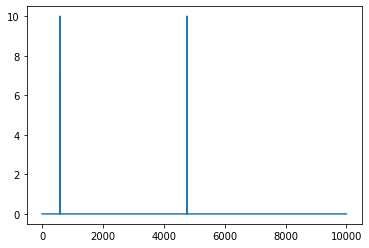

In [11]:
plt.plot(replay_buffer.reward)

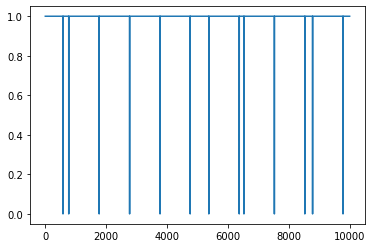

In [12]:
plt.plot(replay_buffer.not_done)

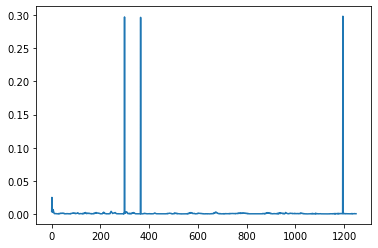

In [13]:
plt.plot(losses)

In [87]:
state, level_seeds = envs.reset()

tensor([[10.]])


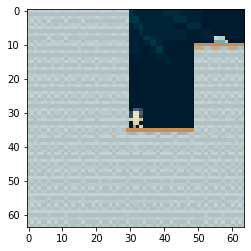

In [273]:
print(reward)
plt.imshow(torch.einsum('nchw->hwc', state).numpy())

In [272]:
action = torch.LongTensor([7]).reshape(-1, 1)
state, reward, done, infos = envs.step(action)

In [11]:
state, action, next_state, reward, done, ind, weights = replay_buffer.sample()

In [172]:
infos

[{'level_seed': 5, 'level_complete': 0}]